In [1]:
import pybullet as p
import numpy as np
from transforms3d.quaternions import *
from transforms3d.euler import *
from transforms3d.axangles import *
import sys
import os
import json
import open3d as o3d
import matplotlib.pyplot as plt

sys.path.append("../")
from env.ycb_scene import SimulatedYCBEnv

pybullet build time: Dec  1 2021 18:33:43


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
'''
get data file name in json file and load mesh in pybullet
then reset robot and object position
'''

file = os.path.join("../object_index", 'ycb_large.json')
with open(file) as f: file_dir = json.load(f)
file_dir = file_dir['test']
file_dir = [f[:-5].split('.')[0][:-2] for f in file_dir]
test_file_dir = list(set(file_dir))

env = SimulatedYCBEnv()
env._load_index_objs(test_file_dir)
state = env.reset(save=False, enforce_face_target=True)

/home/ros/Documents/TM5_900_pybullet/env/models
>>>> target name: 005_tomato_soup_can


In [7]:
# Reset environment without reload object mesh, set "reset_free=True"
state = env.reset(save=False, reset_free=True)

>>>> target name: 004_sugar_box


## Move end effector to relative coordinate

In [4]:
# state: [observation, if_target_lift, ef_pose]
# move target relative to ef posision and get observation (x, y, z, roll, pitch, yaw)

state = env.step(action=np.array([0, 0, 0.1, 0, 0, 0]))

## Move end effector to target in world coordinate


In [5]:
# get current end effector pose
pos, orn = env._get_ef_pose()

new_pos = [pos[0], pos[1] + 0.1, pos[2]]

# solve IK and get desired joint position
jointPoses = env._panda.solveInverseKinematics(new_pos, orn)

# set gripper opened
jointPoses[6] = 0

# remove unnecessary joint
jointPoses = jointPoses[:7].copy()

# If move to world relative coordinate, set "config=True"
obs = env.step(jointPoses, config=True)[0]

## Gripper control

In [6]:
# Execute grasp and lift process, return if target object is lifted
reward = env.retract()
print(reward)

0


In [9]:
# set gripper length to 0 (m), the gripper range is [0, 0.085]
env._panda.move_gripper(0)

for _ in range(150):
    p.stepSimulation()

obs = env._get_observation()

## Get environment observation by RGB-D camera

In [10]:
# only get obvervation
# obs: [seg_pc, rgb+depth+mask(5, 244, 244)]

obs, joint_pos, camera_info, pose_info = env._get_observation()

In [11]:
# visualize point cloud 

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(obs[0][:3].T)
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
o3d.visualization.draw_geometries([pcd]+ [axis_pcd])

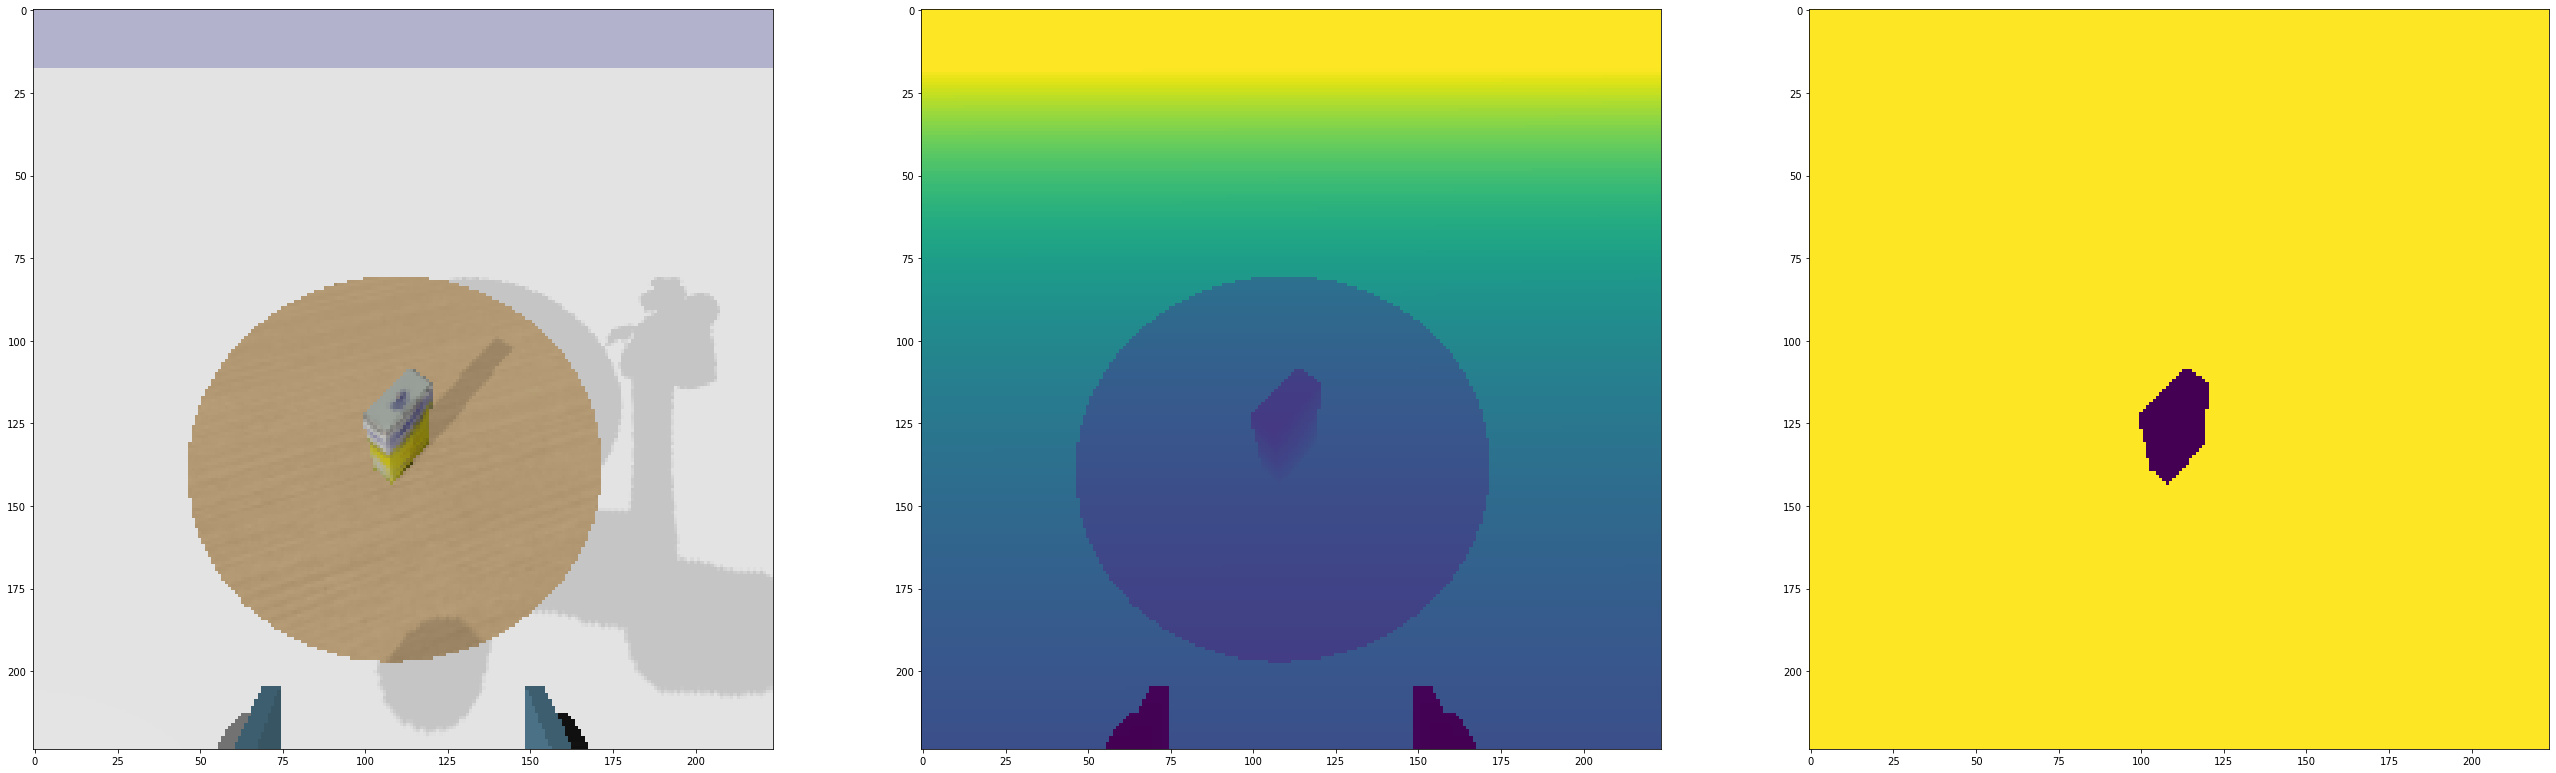

In [12]:
fig=plt.figure(figsize=(61, 61))
fig.add_subplot(1, 4, 1)
plt.imshow(obs[1][:3].T) # RGB
fig.add_subplot(1, 4, 2)
plt.imshow(obs[1][3].T) # Depth
fig.add_subplot(1, 4, 3)
plt.imshow(obs[1][4].T) # Mask
plt.show()